In [77]:
%matplotlib inline
import cv2
from itertools import product, chain
import numpy
import pylab as pl

In [62]:
def gabor(ksize, num):
    filters = []
    ksize = ksize
    for theta in numpy.arange(0, numpy.pi, numpy.pi / num):
#         for lamda in numpy.arange(0, numpy.pi, numpy.pi/4):
        kern = cv2.getGaborKernel((ksize, ksize), 1.0, theta, 1, 2, 0,  ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

In [79]:
def makeRFSfilters(radius=12, sigmas=[1, 2, 4], n_orientations=5):
    """ Generates filters for RFS filterbank.

    Parameters
    ----------
    radius : int, default 28
        radius of all filters. Size will be 2 * radius + 1

    sigmas : list of floats, default [1, 2, 4]
        define scales on which the filters will be computed

    n_orientations : int
        number of fractions the half-angle will be divided in

    Returns
    -------
    edge : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains edge filters on different scales and orientations
    bar : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains bar filters on different scales and orientations
    rot : ndarray (2, 2*radius+1, 2*radius+1)
        contains two rotation invariant filters, Gaussian and Laplacian of
        Gaussian
    """
    def make_gaussian_filter(x, sigma, order=0):
        if order > 2:
            raise ValueError("Only orders up to 2 are supported")
        # compute unnormalized Gaussian response
        response = numpy.exp(-x ** 2 / (2. * sigma ** 2))
        if order == 1:
            response = -response * x
        elif order == 2:
            response = response * (x ** 2 - sigma ** 2)
        # normalize
        response /= numpy.abs(response).sum()
        return response

    def makefilter(scale, phasey, pts, sup):
        gx = make_gaussian_filter(pts[0, :], sigma=3 * scale)
        gy = make_gaussian_filter(pts[1, :], sigma=scale, order=phasey)
        f = (gx * gy).reshape(sup, sup)
        # normalize
        f /= numpy.abs(f).sum()
        return f

    support = 2 * radius + 1
    x, y = numpy.mgrid[-radius:radius + 1, radius:-radius - 1:-1]
    orgpts = numpy.vstack([x.ravel(), y.ravel()])

    rot, edge, bar = [], [], []
    for sigma in sigmas:
        for orient in xrange(n_orientations):
            # Not 2pi as filters have symmetry
            angle = numpy.pi * orient / n_orientations
            c, s = numpy.cos(angle), numpy.sin(angle)
            rotpts = numpy.dot(numpy.array([[c, -s], [s, c]]), orgpts)
            edge.append(makefilter(sigma, 1, rotpts, support))
            bar.append(makefilter(sigma, 2, rotpts, support))
    length = numpy.sqrt(x ** 2 + y ** 2)
    rot.append(make_gaussian_filter(length, sigma=10))
    rot.append(make_gaussian_filter(length, sigma=10, order=2))

    # reshape rot and edge
    edge = numpy.asarray(edge)
    edge = edge.reshape(len(sigmas), n_orientations, support, support)
    bar = numpy.asarray(bar).reshape(edge.shape)
    rot = numpy.asarray(rot)[:, numpy.newaxis, :, :]
    return edge, bar, rot

edge,bar,rot = makeRFSfilters()
filterbank = chain(edge, bar, rot)
for i in filterbank:
    print i
# f = numpy.concatenate((x.reshape(-1, 5, 5), y.reshape(-1, 5, 5), z.reshape(-1, 5, 5)))
# print f

[[[ -1.57925395e-35  -1.42905832e-30  -4.71790647e-26 ...,   4.71790647e-26
     1.42905832e-30   1.57925395e-35]
  [ -5.66739926e-35  -5.12839881e-30  -1.69309437e-25 ...,   1.69309437e-25
     5.12839881e-30   5.66739926e-35]
  [ -1.81995523e-34  -1.64686760e-29  -5.43698407e-25 ...,   5.43698407e-25
     1.64686760e-29   1.81995523e-34]
  ..., 
  [ -1.81995523e-34  -1.64686760e-29  -5.43698407e-25 ...,   5.43698407e-25
     1.64686760e-29   1.81995523e-34]
  [ -5.66739926e-35  -5.12839881e-30  -1.69309437e-25 ...,   1.69309437e-25
     5.12839881e-30   5.66739926e-35]
  [ -1.57925395e-35  -1.42905832e-30  -4.71790647e-26 ...,   4.71790647e-26
     1.42905832e-30   1.57925395e-35]]

 [[ -8.67909728e-10  -1.09230059e-08  -5.55440849e-08 ...,   7.10793823e-51
     3.24939407e-56   7.41005830e-62]
  [ -8.15056874e-10  -1.68978733e-08  -1.55844686e-07 ...,   5.74121538e-47
     4.01350464e-52   1.39931946e-57]
  [ -4.87262022e-10  -1.62027342e-08  -2.50139003e-07 ...,   3.04738233e-43
  

In [75]:
x[0][0]

array([[ -1.57925395e-35,  -1.42905832e-30,  -4.71790647e-26,
         -5.67269475e-22,  -2.47822075e-18,  -3.92063719e-15,
         -2.23523917e-12,  -4.55787492e-10,  -3.28229460e-08,
         -8.15210019e-07,  -6.62086075e-06,  -1.48363196e-05,
         -0.00000000e+00,   1.48363196e-05,   6.62086075e-06,
          8.15210019e-07,   3.28229460e-08,   4.55787492e-10,
          2.23523917e-12,   3.92063719e-15,   2.47822075e-18,
          5.67269475e-22,   4.71790647e-26,   1.42905832e-30,
          1.57925395e-35],
       [ -5.66739926e-35,  -5.12839881e-30,  -1.69309437e-25,
         -2.03573504e-21,  -8.89348192e-18,  -1.40698185e-14,
         -8.02150459e-12,  -1.63566455e-09,  -1.17790264e-07,
         -2.92550838e-06,  -2.37599921e-05,  -5.32424485e-05,
         -0.00000000e+00,   5.32424485e-05,   2.37599921e-05,
          2.92550838e-06,   1.17790264e-07,   1.63566455e-09,
          8.02150459e-12,   1.40698185e-14,   8.89348192e-18,
          2.03573504e-21,   1.69309437e-25,

In [63]:
filters = gabor(5, 16)
f = numpy.asarray(filters)

# filters = [f[i] for i in range(f.shape[0])]
# filters = np.array([f[i][0] for i in range(2)])
# print filters
# print np.tile(filters, (1,3,1)).reshape(2,3,5,5)

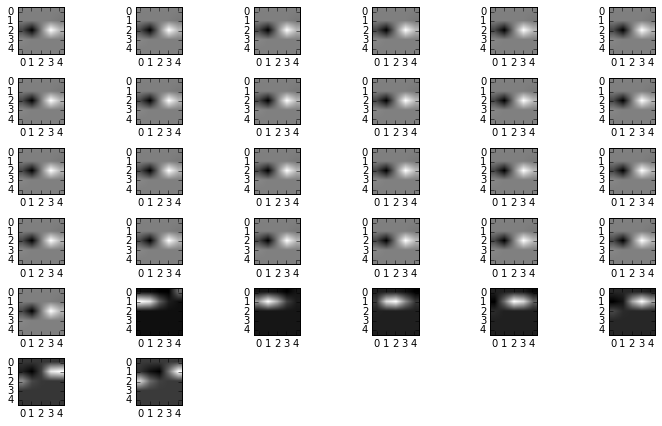

In [72]:
pl.figure(figsize=(10,6))
for k in range(32):
     pl.subplot(6,6,k+1)
     pl.imshow(f[k], cmap='gray' )
pl.tight_layout()

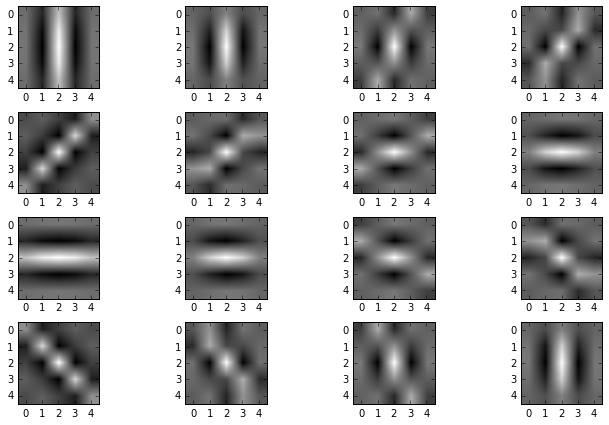

In [47]:
pl.figure(figsize=(10,6))
for k in range(16):
     pl.subplot(4,4,k+1)
     pl.imshow(f[k].reshape(5,5), cmap='gray' )
pl.tight_layout()

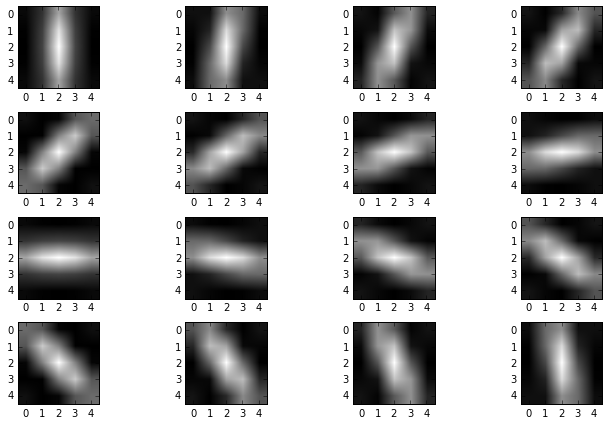

In [29]:
pl.figure(figsize=(10,6))
for k in range(16):
     pl.subplot(4,4,k+1)
     pl.imshow(f[k].reshape(5,5), cmap='gray' )
pl.tight_layout()